
## Libraries


In [ ]:

!pip install mlxtend
!pip install onnxmltools
!pip install onnxruntime
!pip install onnxruntime onnxmltools skl2onnx


In [1]:

import numpy as np
import torch
import pandas as pd
import sklearn
import random

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [2]:

import matplotlib.pyplot as plt

from mlxtend.plotting import heatmap
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

## coefficient of determination 
from sklearn.metrics import r2_score


In [3]:

##import xgboost as xgb


In [4]:

import onnxruntime as rt
import onnxmltools

from skl2onnx.common.data_types import FloatTensorType



## Parameters 


In [5]:

## 0.001, 0.0001, 0.0003, 0.01, 0.03

batch_size    = 32
learning_rate = 0.005 ## 0.001
N_Epochs      = 100

epsilon = 0.0001



## Read data


In [6]:

path_data = 'diabetes.csv'

diabetes_raw_data = pd.read_csv( path_data, delimiter="," )


In [7]:

diabetes_raw_data


,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,148,72,35,0,33.6,0.627,50,1
1,85,66,29,0,26.6,0.351,31,0
2,183,64,0,0,23.3,0.672,32,1
3,89,66,23,94,28.1,0.167,21,0
4,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...
763,101,76,48,180,32.9,0.171,63,0
764,122,70,27,0,36.8,0.340,27,0
765,121,72,23,112,26.2,0.245,30,0
766,126,60,0,0,30.1,0.349,47,1


In [8]:

headers_list = diabetes_raw_data.columns.values.tolist()

headers_list


['Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age',
 'Outcome']


## Data Analysis

* Correlation matrix


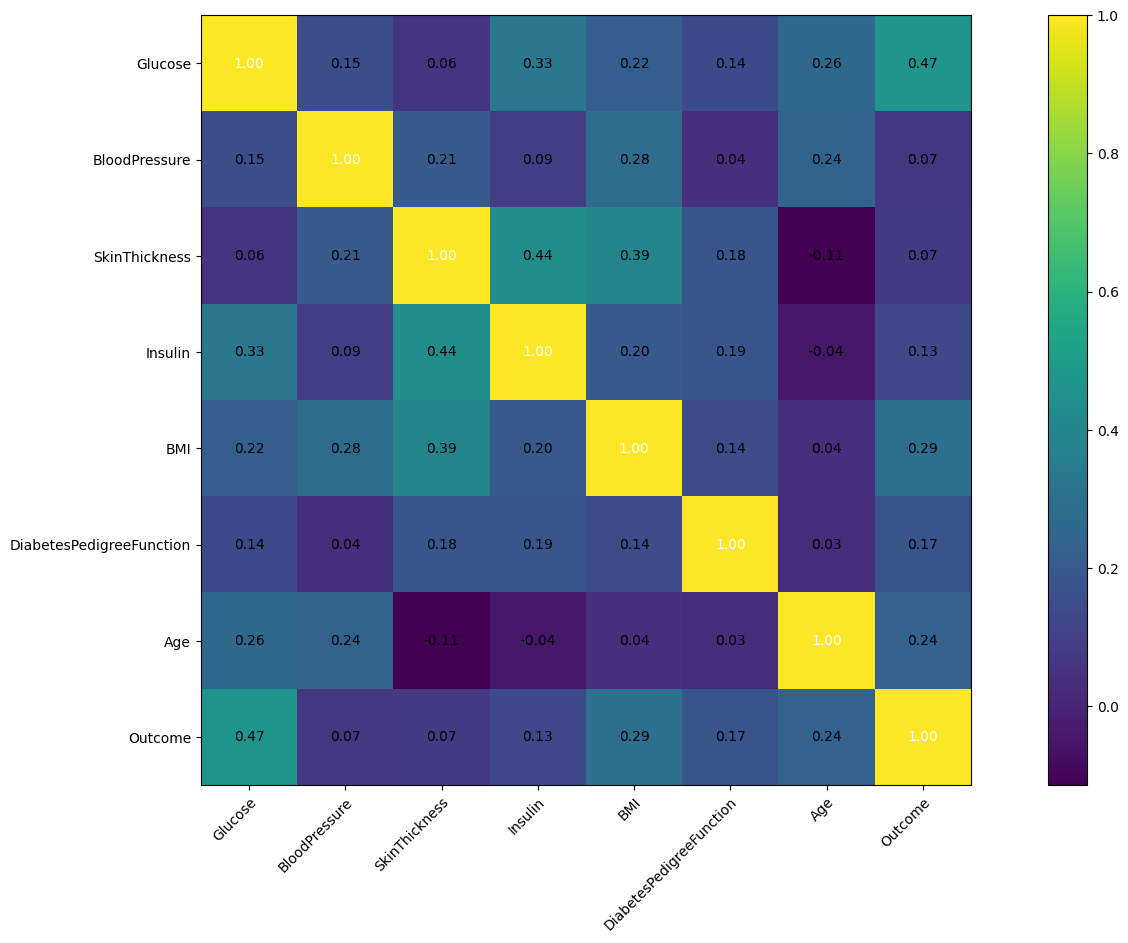

In [9]:

cm = np.corrcoef(   diabetes_raw_data[headers_list].values.T   )
hm = heatmap(cm, row_names=headers_list, column_names=headers_list, figsize=(20,10))
plt.show()




## Process Data


In [10]:

## Convert Pandas to Numpy

diabetes_raw_data_np = diabetes_raw_data.to_numpy()



In [11]:

diabetes_raw_data_np


array([[148.   ,  72.   ,  35.   , ...,   0.627,  50.   ,   1.   ],
       [ 85.   ,  66.   ,  29.   , ...,   0.351,  31.   ,   0.   ],
       [183.   ,  64.   ,   0.   , ...,   0.672,  32.   ,   1.   ],
       ...,
       [121.   ,  72.   ,  23.   , ...,   0.245,  30.   ,   0.   ],
       [126.   ,  60.   ,   0.   , ...,   0.349,  47.   ,   1.   ],
       [ 93.   ,  70.   ,  31.   , ...,   0.315,  23.   ,   0.   ]])

In [12]:

diabetes_raw_data_np.shape


(768, 8)

In [13]:

X = diabetes_raw_data_np[:, :-1]


y = diabetes_raw_data_np[:, 7:8]


In [14]:

y


array([[1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],

In [15]:

print(X.shape)

print(y.shape)


(768, 7)
(768, 1)


In [16]:

random_seed = int( random.random() * 100 )     ## 42


In [17]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)


In [18]:

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(614, 7)
(154, 7)
(614, 1)
(154, 1)


In [19]:

y_test.dtype 


dtype('float64')


## Fix in case float64 error


In [20]:

## fix data type

X_train = X_train.astype(  np.float32  )
X_test  = X_test.astype(   np.float32  )
y_train = y_train.astype(  np.float32  )
y_test  = y_test.astype(   np.float32  )


In [21]:

X_train_tr = torch.from_numpy(X_train)
X_test_tr  = torch.from_numpy(X_test)
y_train_tr = torch.from_numpy(y_train)
y_test_tr  = torch.from_numpy(y_test)



## Normalization

* Normalizartion
* Standardization (*)


In [22]:


x_means      = X_train_tr.mean(0, keepdim=True ) 

x_deviations = X_train_tr.std( 0, keepdim=True) + epsilon


In [23]:

x_means


tensor([[122.2150,  68.8664,  20.2345,  82.7622,  31.6964,   0.4776,  33.1482]])

In [24]:

x_deviations


tensor([[ 31.8323,  19.9369,  15.9415, 118.9753,   8.0114,   0.3421,  11.6634]])


## Create the DataLoader


In [25]:

train_ds = TensorDataset( X_train_tr, y_train_tr  )


In [26]:

train_dl = DataLoader( train_ds, batch_size, shuffle=True  )


In [27]:

train_dl



## Neural Network Architectures


In [28]:

## Linear Regression

class LinRegNet(nn.Module):
    ## init the class
    def __init__(self, x_means, x_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        
        self.linear1 = nn.Linear(11, 1)
        
    ## perform inference
    def forward(self, x):
        
        x = (x - self.x_means) / self.x_deviations
        
        y_pred = self.linear1(x)
        ## return torch.round( y_pred )
        return y_pred
    



In [29]:


## MLP


        
    


In [34]:

## Deep Learning with 2 hidden layers

class DL_Net(nn.Module):
    ## init the class
    def __init__(self, x_means, x_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        
        self.linear1 = nn.Linear(7, 4)
        self.act1    = nn.ReLU()
        self.linear2 = nn.Linear(4, 2)
        self.act2    = nn.ReLU()
        self.linear3 = nn.Linear(2, 1)
        self.dropout = nn.Dropout(0.25)
        
    ## perform inference
    def forward(self, x):
        
        x = (x - self.x_means) / self.x_deviations
        
        x = self.linear1(x)
        x = self.act1(x)
        x = self.linear2(x)
        x = self.act2(x)
        ## x = self.dropout(x)
        y_pred = self.linear3(x)
        
        ## return torch.round( y_pred )
        return y_pred


In [35]:

## Linear plus Nonlinear
## f1 + f2

class LinearPlusNonLinear_Net(nn.Module):
    def __init__(self, x_means, x_deviations):
        super().__init__()
        
        self.x_means = x_means
        self.x_deviations = x_deviations
        
        # F1
        self.f1_linear1 = nn.Linear(7, 1)
        
        # F2
        self.f2_linear1 = nn.Linear(7, 14)
        self.f2_act1 = nn.Sigmoid()
        self.f2_linear2 = nn.Linear(14, 1)
    
    def forward(self, x):
        x = (x - self.x_means) / self.x_deviations
        
        # F1
        f1 = self.f1_linear1(x)  # Corrected method name
        
        # F2
        f2 = self.f2_linear1(x)
        f2 = self.f2_act1(f2)
        f2 = self.f2_linear2(f2)
        
        y_pred = f1 + f2
        return y_pred


## Training Loop

In [36]:

def training_loop( N_Epochs, model, loss_fn, opt  ):
    
    for epoch in range(500):
        for xb, yb in train_dl:
            
            y_pred = model(xb)
            loss   = loss_fn(y_pred, yb)
            
            opt.zero_grad()
            loss.backward()
            opt.step()
            
        if epoch % 20 == 0:
            print(epoch, "loss=", loss)
            
        



In [37]:
## model = LinRegNet( x_means, x_deviations  )
model = DL_Net( x_means, x_deviations  )

opt     = torch.optim.Adam(    model.parameters(), lr=learning_rate )
loss_fn = F.mse_loss

training_loop(  N_Epochs, model, loss_fn, opt  )


0 loss= tensor(0.4355, grad_fn=<MseLossBackward0>)
20 loss= tensor(0.0694, grad_fn=<MseLossBackward0>)
40 loss= tensor(0.0759, grad_fn=<MseLossBackward0>)
60 loss= tensor(0.1936, grad_fn=<MseLossBackward0>)
80 loss= tensor(0.1160, grad_fn=<MseLossBackward0>)
100 loss= tensor(0.1543, grad_fn=<MseLossBackward0>)
120 loss= tensor(0.0702, grad_fn=<MseLossBackward0>)
140 loss= tensor(0.0979, grad_fn=<MseLossBackward0>)
160 loss= tensor(0.0515, grad_fn=<MseLossBackward0>)
180 loss= tensor(0.1708, grad_fn=<MseLossBackward0>)
200 loss= tensor(0.2535, grad_fn=<MseLossBackward0>)
220 loss= tensor(0.1053, grad_fn=<MseLossBackward0>)
240 loss= tensor(0.0645, grad_fn=<MseLossBackward0>)
260 loss= tensor(0.0639, grad_fn=<MseLossBackward0>)
280 loss= tensor(0.0278, grad_fn=<MseLossBackward0>)
300 loss= tensor(0.1262, grad_fn=<MseLossBackward0>)
320 loss= tensor(0.1138, grad_fn=<MseLossBackward0>)
340 loss= tensor(0.1006, grad_fn=<MseLossBackward0>)
360 loss= tensor(0.0737, grad_fn=<MseLossBackward0>)


## Evaluate Model


In [38]:

y_pred_test = model( X_test_tr )


In [39]:

y_pred_test.shape


torch.Size([154, 1])

In [40]:

## y_pred_test


In [41]:

print( "Testing R**2: ", r2_score(  y_test_tr.numpy(),  y_pred_test.detach().numpy()     )  ) 


Testing R**2:  0.2944449668560932


In [42]:

y_pred_test.shape


torch.Size([154, 1])

In [43]:

y_test_tr.shape


torch.Size([154, 1])

In [44]:

len(X_test_tr)


154

In [45]:

list_preds = []
list_reals = []

for i in range(len(X_test_tr)):
    print("************************************")
    print("pred, real")
    np_real =   y_test_tr[i].detach().numpy()
    np_pred = y_pred_test[i].detach().numpy()
    print(( np_pred  , np_real))
    list_preds.append(np_pred[0])
    list_reals.append(np_real[0])

************************************
pred, real
(array([0.17285566], dtype=float32), array([1.], dtype=float32))
************************************
pred, real
(array([0.03096737], dtype=float32), array([0.], dtype=float32))
************************************
pred, real
(array([0.38454646], dtype=float32), array([1.], dtype=float32))
************************************
pred, real
(array([0.08865552], dtype=float32), array([0.], dtype=float32))
************************************
pred, real
(array([0.15723561], dtype=float32), array([1.], dtype=float32))
************************************
pred, real
(array([0.74858606], dtype=float32), array([1.], dtype=float32))
************************************
pred, real
(array([0.12206686], dtype=float32), array([1.], dtype=float32))
************************************
pred, real
(array([0.1943482], dtype=float32), array([1.], dtype=float32))
************************************
pred, real
(array([1.1774127], dtype=float32), array([1.], d


## Deploy PyTorch Model


In [46]:

model.eval()

dummy_input = torch.randn(1, 7)

input_names  = ["input1"]
output_names = ["output1"]

torch.onnx.export(
        model, 
        dummy_input,
        "DLnet_Diabetes.onnx",
        verbose=False,
        input_names = input_names,
        output_names = output_names
        
)



## XGBoost


In [ ]:

regressor = xgb.XGBRegressor(

        n_estimators=100,
        reg_lambda=1,
        gamma=0,
        max_depth=3
)


In [ ]:

regressor.fit(X_train, y_train)


In [ ]:

y_pred = regressor.predict(X_test)


In [ ]:

y_pred.shape


In [ ]:

y_pred


In [ ]:


r2_score(y_test, y_pred)



## Deploy XGBoost Model

* ONNX and GitHub


In [ ]:

initial_types = [(
          'float_input',
          FloatTensorType(  [None, 11 ]  )

)]





In [ ]:

onnx_model = onnxmltools.convert_xgboost(regressor, initial_types=initial_types)

onnxmltools.utils.save_model(onnx_model, 'xgboost_WineQuality_ort.onnx')


In [ ]:

sess = rt.InferenceSession('xgboost_WineQuality_ort.onnx')


In [ ]:

input_name = sess.get_inputs()[0].name


In [ ]:

input_name


In [ ]:

label_name = sess.get_outputs()[0].name


In [ ]:

label_name


In [ ]:

pred_ort = sess.run(  [label_name], {input_name: X_test.astype(np.float32)}  )


In [ ]:
pred_ort[0]